In [1]:
##- standard imports -##
import math
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

##- Additional Imports -##
import collections
from sklearn.cluster import KMeans
from collections import Counter
%matplotlib inline

path_to_ims = "../images"

**Sobel Filtering**
---

Computer vision algorithm centered on extracting edge information from an image (I.E. Image segmentation). Useful in applications like self driving cars etc. See image segmentation notes for more info

### The algorithm

**Sobel Algorithm mathematically**
---

**Gaussian Blur**

  - $\epsilon \sim \mathcal{N} (0, 1)$ : For an image normalized to $[0,1]$
  - $0 \geq \forall{x}, \forall{y} \leq 1$ in Image I : $x + \epsilon, y+ \epsilon$

**Decomposition**

The sobel filter algorithm can be implemented by decomposting the convolutions into their horizontal and vertical operations. This is why in the algorithm below we can multi process over the width and height operations.

**Convolution kernels**

The goal of the sobel operator is to measure the spatial (visual) gradient and yield the edge at the intersection of the two gradients. To do this we operate over a pair of NxN convolutional kernels:

  - $K(X) := \mathbb{R}^{N x N}$
  - $K(Y) := K(X)$ rotated by 90 degrees 

The second kernel above is the first kernel rotated by 90 degrees. In the final step we combine the two x and y image gradients using the first formula below. However it is possible to compute an approximate norm and follow the second formula:

  - $G = \sqrt{K(X)^2 + K(Y)^2}$
  - $G = |K(X)| + |K(Y)|$

We can also calculate the angle of orientation for an edge using the formula:

  - $\Theta(e) = arctan(\frac{K(Y)}{K(X)})$

In [2]:
# helper functions
def print_graphs(images, bins=256):
    ### - TODO: Add x, y labels, and graph label for each plot - ###
    fig1, ax1 = plt.subplots(len(images))
    for i, x in enumerate(images):
        ax1[i].hist(x.ravel(),bins,[0,bins])

def pad_image(img: np.ndarray, kernel: list[int]) -> np.ndarray:
    # Apply padding to the image
    p_h = int((kernel[0] - 1) / 2)
    p_w = int((kernel[1] - 1) / 2)
    padded_image = np.zeros((img.shape[0] + (2 * p_h), img.shape[1] + (2 * p_w)))
    padded_image[p_h:padded_image.shape[0] - p_h, p_w:padded_image.shape[1] - p_w] = img
    return padded_image

def get_image_xgrad(outputH: np.ndarray, img: np.ndarray, padded_image: np.ndarray, kernel: list[int]):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            try:
                outputH[i][j] = abs(np.sum(np.array([1,0,-1]).T @ (np.array([1,2,1]) @ padded_image[i:i+kernel[0], j:j+kernel[1]]))) #Decomposability of sobel filters
            except ValueError: ###was useful in border handling
                print(i,j)
    return outputH

def get_image_ygrad(outputV: np.ndarray, img: np.ndarray, padded_image: np.ndarray, kernel: list[int]):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            try:
                outputV[i][j] = abs(np.sum(np.array([1,2,1]).T @ (np.array([-1,0,1]) @ padded_image[i:i+kernel[0], j:j+kernel[1]]))) #Decomposability of sobel filters
            except ValueError: ###was useful in border handling
                print(i,j)
    return outputV
 
#sobel function
def Sobel_Filter(img, kernel=[3,3]): #This function will kind of just assume 3x3
    outputH = np.zeros(img.shape)
    outputV = np.zeros(img.shape) #We have 3 outputs, this function will display histograms for Horizontal and vertical
    output = np.zeros(img.shape)
    
    ###Smooth images###
    img = cv.GaussianBlur(img, (7,7), np.std(img)/4) # The amount of gaussian blur can directly determine the sharpness of the sobel filter edge
    
    ###Unsure of if this is useful for edge detection but since we apply the same convolution algorithm:###
    ###Convert to padded image###
    padded_image = pad_image(img, kernel)
    
    #Convolve with filters Horizontal
    outputH = get_image_xgrad(outputH, img, padded_image, kernel)
    outputV = get_image_ygrad(outputV, img, padded_image, kernel)
    
    assert(outputH.shape == img.shape and outputV.shape == img.shape) #quality of life
    
    ###Normalize###
    outputHN = (outputH-np.min(outputH)) / (np.max(outputH)-np.min(outputH))
    outputVN = (outputV-np.min(outputV)) / (np.max(outputV)-np.min(outputV))
    
    print('Horizontal Range: ' + str((np.min(outputHN), np.max(outputHN))))
    print('Vertical Range: ' + str((np.min(outputVN), np.max(outputVN))))
    
    ###Merge horizontal and vertical###
    output = np.sqrt(outputH**2 + outputV**2)
    
    outputN = (output-np.min(output)) / (np.max(output)-np.min(output))
    
    return [outputHN*255, outputVN*255, outputN*255] # scale back to image output

Horizontal Range: (0.0, 1.0)
Vertical Range: (0.0, 1.0)
Horizontal Gradient
Vertical Gradient
Approximated Gradient


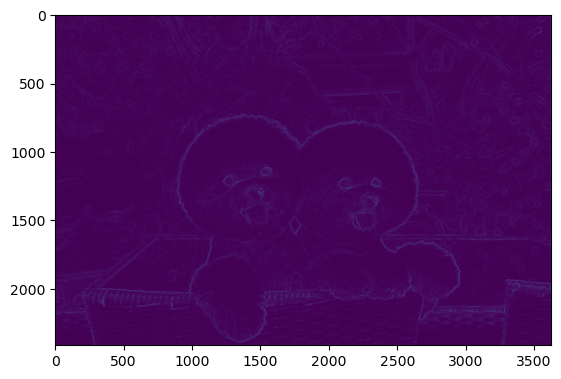

In [3]:
im1 = cv.imread(f"{path_to_ims}/image1.jpg")
# convert to grayscale
gim1 = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
im2 = np.zeros_like(im1)
im2[:,:,0] = gim1 # To display the image correctly you'll need to send the grey channel to each of the three image channels
im2[:,:,1] = gim1
im2[:,:,2] = gim1

[horizontal, vertical, neutral] = Sobel_Filter(gim1)
print('Horizontal Gradient')
plt.imshow(horizontal)
print('Vertical Gradient')
plt.imshow(vertical)
print('Approximated Gradient')
plt.imshow(neutral)